In [1]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train_identity_df  = pd.read_csv('dataset/train_identity.csv')
train_transaction_df  = pd.read_csv('dataset/train_transaction.csv')

In [3]:
# Merge the two dataframes on the 'TransactionID' column
# Using a left join so that all transactions are kept, even if no identity info exists
data = pd.merge(train_transaction_df, train_identity_df, on='TransactionID', how='left')

In [4]:

# Convert TransactionDT to datetime
reference_date = pd.Timestamp("2017-01-01")  # Assuming a reference date
data['transaction_time'] = data['TransactionDT'].apply(lambda x: reference_date + pd.Timedelta(seconds=x))
data['transaction_date'] = data['transaction_time'].dt.date
data['transaction_hour'] = data['transaction_time'].dt.hour
data['transaction_month'] = data['transaction_time'].dt.month_name()
data['transaction_day'] = data['transaction_time'].dt.day_name()


In [5]:
# Fraud Dataset Overview

In [6]:

total_transactions = len(data)
fraud_transactions = data[data['isFraud'] == 1]
fraud_rate = len(fraud_transactions) / total_transactions * 100

print(f"Total Transactions: {total_transactions}")
print(f"Fraudulent Transactions: {len(fraud_transactions)}")
print(f"Fraud Rate: {fraud_rate:.2f}%")

Total Transactions: 590540
Fraudulent Transactions: 20663
Fraud Rate: 3.50%


In [7]:
# Time Delta Features Analysis
time_delta_cols = [col for col in data.columns if col.startswith('D')]
time_delta_stats = fraud_transactions[time_delta_cols].describe()
print("\nTime Delta Features Statistics:")
print(time_delta_stats)


Time Delta Features Statistics:
                 D1           D2           D3            D4            D5  \
count  20617.000000  7870.000000  9619.000000  14567.000000  10880.000000   
mean      38.711306    77.774206    11.744880     72.102904     13.687776   
std      100.915599   128.697847    42.005468    140.656090     51.891635   
min        0.000000     0.000000     0.000000      0.000000      0.000000   
25%        0.000000     2.000000     0.000000      0.000000      0.000000   
50%        0.000000    16.000000     1.000000      1.000000      0.000000   
75%       14.000000    95.000000     5.000000     61.000000      3.000000   
max      637.000000   637.000000   582.000000    667.000000    625.000000   

                D6           D7           D8           D9           D10  \
count  7718.000000  5790.000000  7827.000000  7827.000000  16777.000000   
mean     45.856439    11.292228    49.309191     0.520000     52.363653   
std     101.424445    46.743057   133.254994    

# Temporal patterns in fraudulent transactions

In [8]:
def analyze_temporal_fraud_patterns(data):

    plt.figure(figsize=(15, 10))
    
    # Fraud by Hour
    plt.subplot(2, 2, 1)
    fraud_by_hour = fraud_transactions.groupby('transaction_hour').size()
    fraud_by_hour.plot(kind='bar')
    plt.title('Fraudulent Transactions by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Fraudulent Transactions')
    plt.xticks(rotation=45)
    
    # Fraud by Day of Week
    plt.subplot(2, 2, 2)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_fraud = fraud_transactions.groupby('transaction_day').size()
    day_fraud = day_fraud.reindex(day_order)
    day_fraud.plot(kind='bar')
    plt.title('Fraudulent Transactions by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Fraudulent Transactions')
    plt.xticks(rotation=45)
    
    # Fraud by Month
    plt.subplot(2, 2, 3)
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_fraud = fraud_transactions.groupby('transaction_month').size()
    month_fraud = month_fraud.reindex(month_order)
    month_fraud.plot(kind='bar')
    plt.title('Fraudulent Transactions by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Fraudulent Transactions')
    plt.xticks(rotation=45)
    
    # Heat of Fraud probablity by Hour and Day of week
    plt.subplot(2, 2, 4)
    fraud_prob_by_hour_day = data.groupby(['transaction_hour', 'transaction_day'])['isFraud'].mean()
    fraud_prob_matrix = fraud_prob_by_hour_day.unstack()
    
    sns.heatmap(fraud_prob_matrix, cmap='YlOrRd', annot=True, fmt='.2%')
    plt.title('Fraud Probability by Hour and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.tight_layout()
    plt.show()

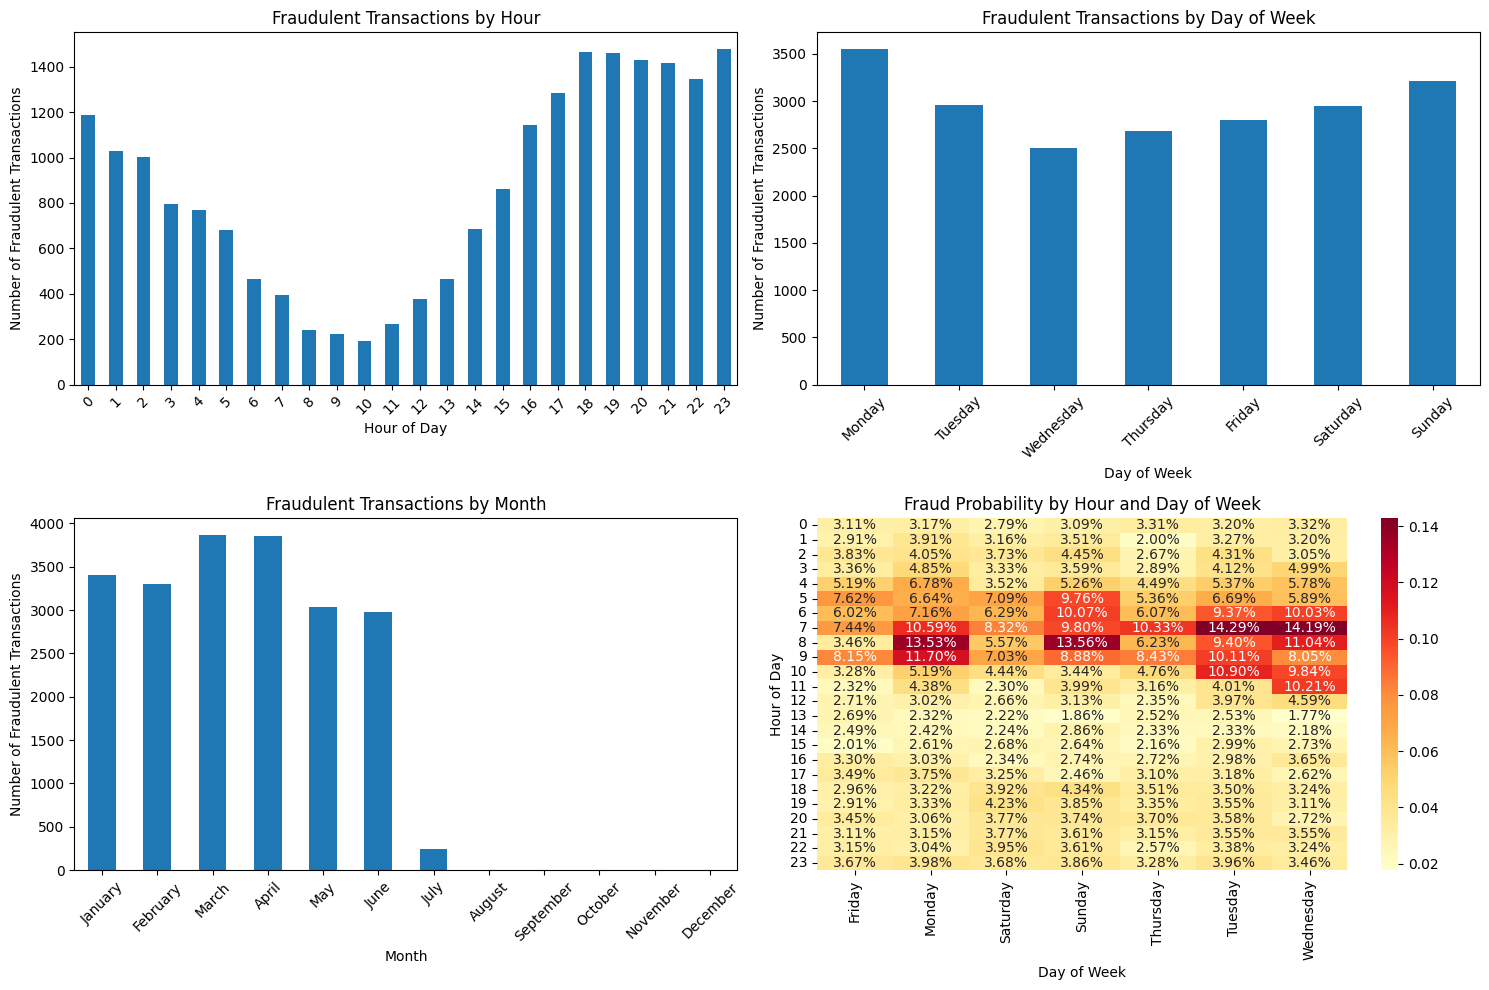

In [9]:
analyze_temporal_fraud_patterns(data)

### Create moving averages and identify seasonal trends

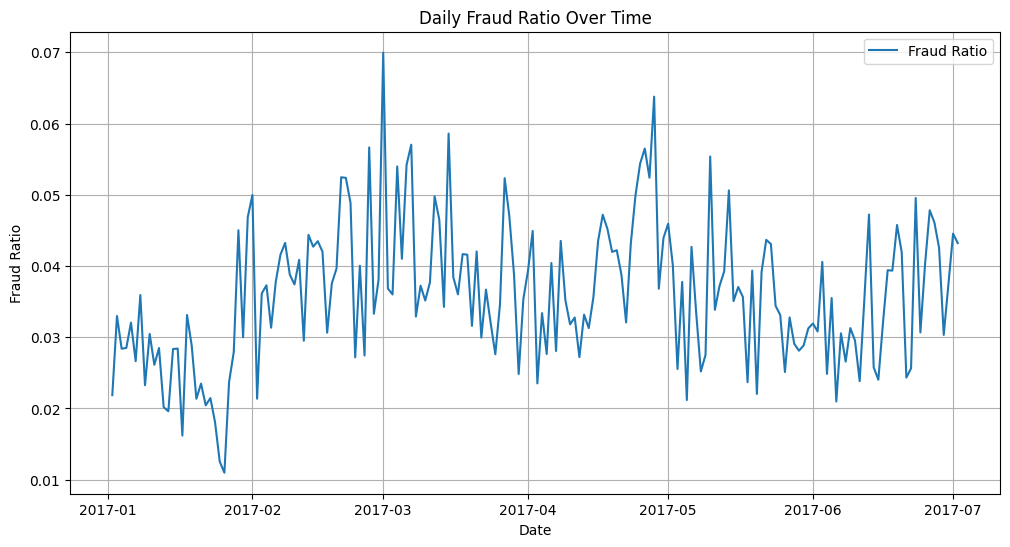

In [10]:
# Group by date to calculate fraud ratio
daily_fraud = data.groupby('transaction_date').agg(
    total_transactions=('isFraud', 'count'),
    fraudulent_transactions=('isFraud', 'sum')
)
daily_fraud['fraud_ratio'] = daily_fraud['fraudulent_transactions'] / daily_fraud['total_transactions']

# Plot daily fraud ratio
plt.figure(figsize=(12, 6))
plt.plot(daily_fraud.index, daily_fraud['fraud_ratio'],  label='Fraud Ratio')
plt.title("Daily Fraud Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("Fraud Ratio")
plt.legend()
plt.grid()
plt.show()


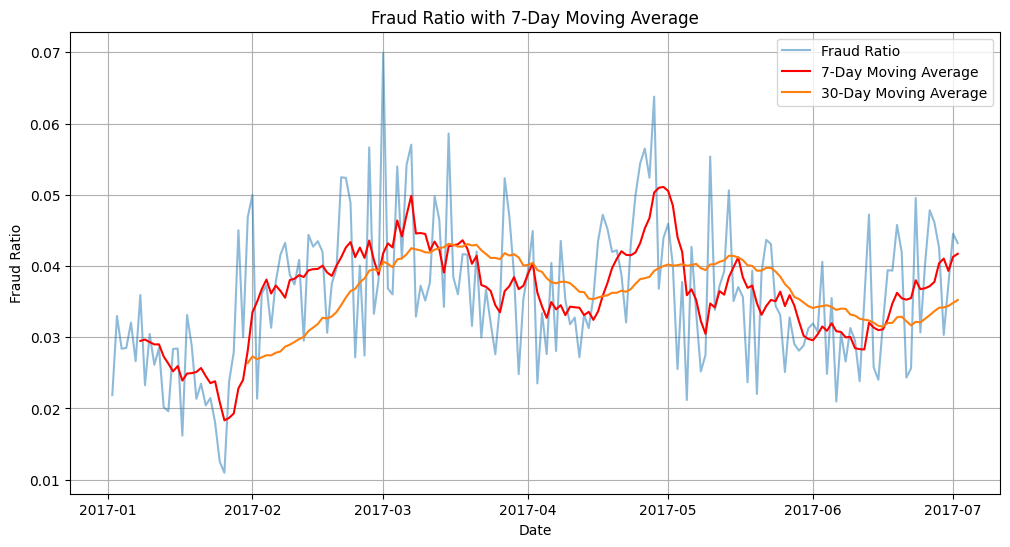

In [11]:
# Add a moving average column
daily_fraud['fraud_ratio_ma_7'] = daily_fraud['fraud_ratio'].rolling(window=7).mean()

daily_fraud['fraud_ratio_ma_30'] = daily_fraud['fraud_ratio'].rolling(window=30).mean()

# Plot fraud ratio with moving average
plt.figure(figsize=(12, 6))
plt.plot(daily_fraud.index, daily_fraud['fraud_ratio'], label='Fraud Ratio', alpha=0.5)
plt.plot(daily_fraud.index, daily_fraud['fraud_ratio_ma_7'], label='7-Day Moving Average', color='red')
plt.plot(daily_fraud.index, daily_fraud['fraud_ratio_ma_30'], label='30-Day Moving Average')#, color='red')
plt.title("Fraud Ratio with 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Fraud Ratio")
plt.legend()
plt.grid()
plt.show()



In [12]:
# Calculate the difference between fraud_ratio and moving averages to extract seasonal trends

daily_fraud['seasonality_7'] = daily_fraud['fraud_ratio'] - daily_fraud['fraud_ratio_ma_7']
daily_fraud['seasonality_30'] = daily_fraud['fraud_ratio'] - daily_fraud['fraud_ratio_ma_30']

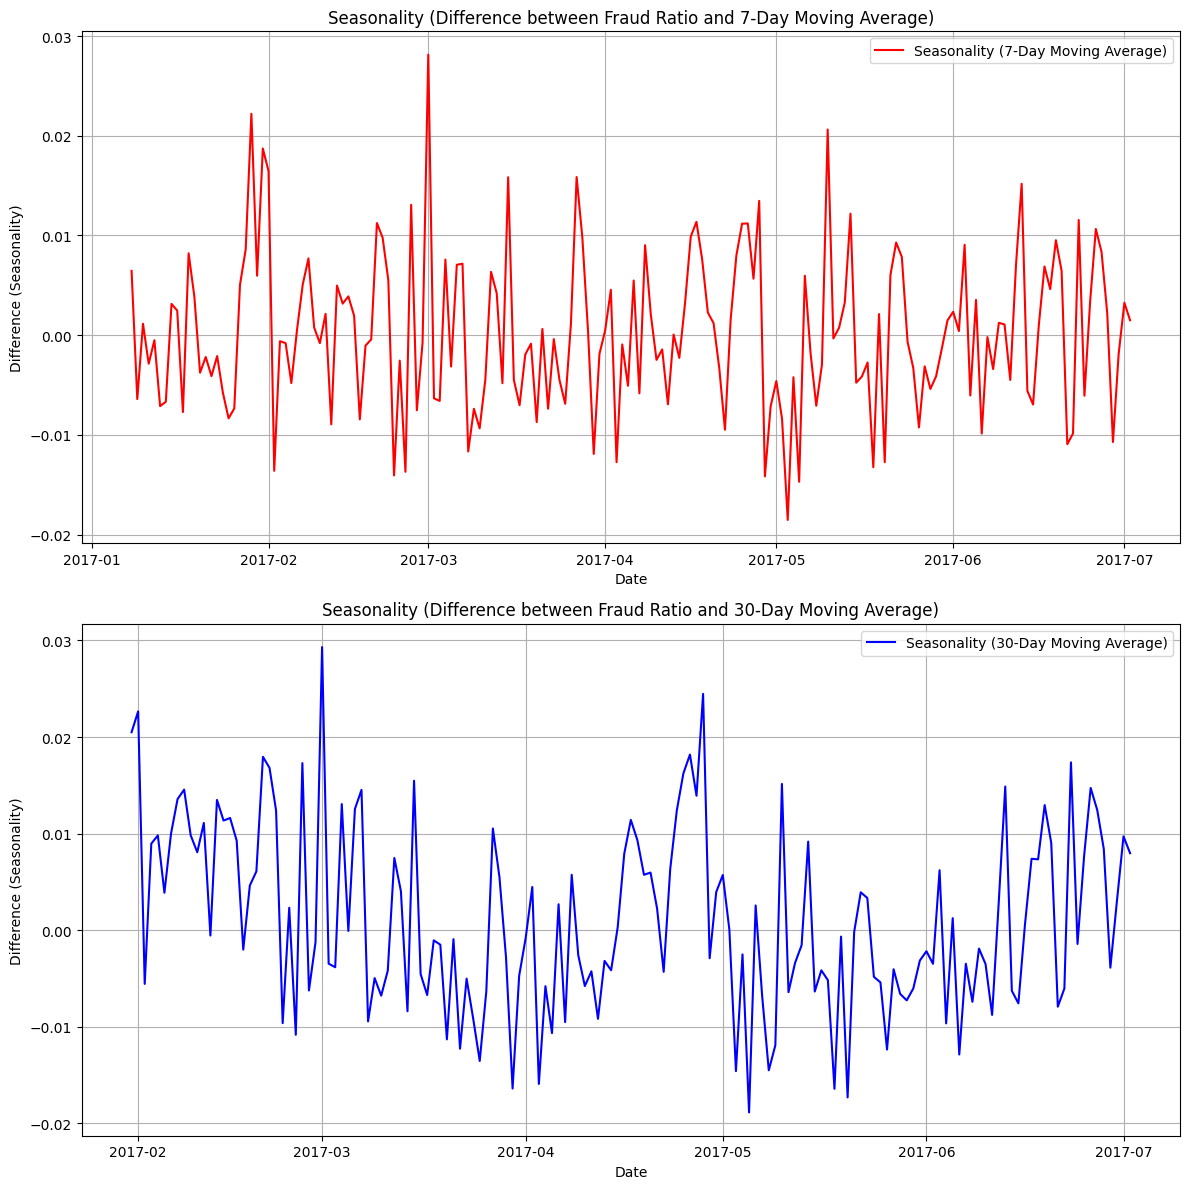

In [13]:
daily_fraud['seasonality_7'] = daily_fraud['fraud_ratio'] - daily_fraud['fraud_ratio_ma_7']
daily_fraud['seasonality_30'] = daily_fraud['fraud_ratio'] - daily_fraud['fraud_ratio_ma_30']

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot seasonality for 7-Day Moving Average
ax1.plot(daily_fraud.index, daily_fraud['seasonality_7'], label='Seasonality (7-Day Moving Average)', color='red')
ax1.set_title("Seasonality (Difference between Fraud Ratio and 7-Day Moving Average)")
ax1.set_xlabel("Date")
ax1.set_ylabel("Difference (Seasonality)")
ax1.legend()
ax1.grid()

# Plot seasonality for 30-Day Moving Average
ax2.plot(daily_fraud.index, daily_fraud['seasonality_30'], label='Seasonality (30-Day Moving Average)', color='blue')
ax2.set_title("Seasonality (Difference between Fraud Ratio and 30-Day Moving Average)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Difference (Seasonality)")
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()


# Develop statistical measures for anomaly detection using the Transation amount

In [14]:
## USING THE Z_SCORE TO IDENTIFY ANOMALIES IN THE DATASET

In [15]:
def z_score_anomaly_detection(data, column, threshold=3):
    """
    Detect anomalies in a column using Z-score.
    """
    mean = data[column].mean()
    std = data[column].std()
    data['z_score'] = (data[column] - mean) / std
    anomalies = data[abs(data['z_score']) > threshold]
    print(f"Anomalies detected using Z-score in {column}: {len(anomalies)}")
    return anomalies


In [16]:
anomalies = z_score_anomaly_detection(data, 'TransactionAmt', threshold=3)


Anomalies detected using Z-score in TransactionAmt: 10093


In [17]:
anomalies.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_37,id_38,DeviceType,DeviceInfo,transaction_time,transaction_date,transaction_hour,transaction_month,transaction_day,z_score
60,2987060,0,87581,2454.00,W,2213,556.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,2017-01-02 00:19:41,2017-01-02,0,January,Monday,9.696222
110,2987110,0,88380,1153.95,W,1214,523.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,2017-01-02 00:33:00,2017-01-02,0,January,Monday,4.260378
133,2987133,0,88647,2594.95,W,14349,170.0,150.0,mastercard,195.0,...,NaN,NaN,NaN,NaN,2017-01-02 00:37:27,2017-01-02,0,January,Monday,10.285570
135,2987135,0,88671,3000.00,W,2616,NaN,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,2017-01-02 00:37:51,2017-01-02,0,January,Monday,11.979188
163,2987163,0,89103,973.95,W,17188,321.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,2017-01-02 00:45:03,2017-01-02,0,January,Monday,3.507752
